In [2]:
import sys
sys.path.append('..')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [4]:
from geo.california import California
from geo.sites import Sites
from geo.utils import get_transform
from geo.distance import Distance

In [9]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

In [6]:
d = Distance()

../geo/sites.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State Code'] = pd.to_numeric(data['State Code'], errors='coerce')


In [7]:
cali = d.cali

In [56]:
def get_edges(D, n_retries=1, sigma_D=5, seed=0):
    
    np.random.seed(seed)
    
    mst = minimum_spanning_tree(D)
    edges = set(tuple(i) for i in np.argwhere(mst))
    
    for i in range(n_retries):
        mst = minimum_spanning_tree(D + np.random.normal(loc=0, scale=sigma_D, size=D.shape))
        edges = edges.union(set(tuple(i) for i in np.argwhere(mst)))
        
    return list(edges)

def get_L(D):
    
    edges = get_edges(D)
    xi, yi = np.array(edges).T
    A = np.zeros_like(D)
    A[xi, yi] = 1
    A = A + A.T
    
    return np.diag(A.sum(0)) - A

In [57]:
D = d.get_penalty_matrix()
L = get_L(D)
lam, U = np.linalg.eigh(L)
edges = get_edges(D)

<IPython.core.display.Javascript object>


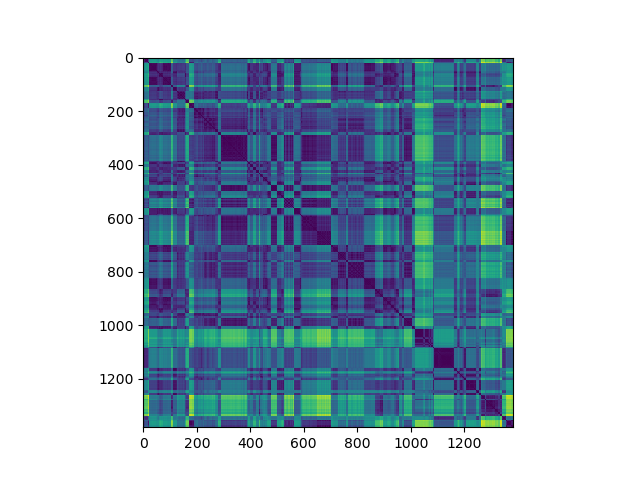

In [53]:
plt.figure()

plt.imshow(D)

../geo/sites.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State Code'] = pd.to_numeric(data['State Code'], errors='coerce')


<IPython.core.display.Javascript object>


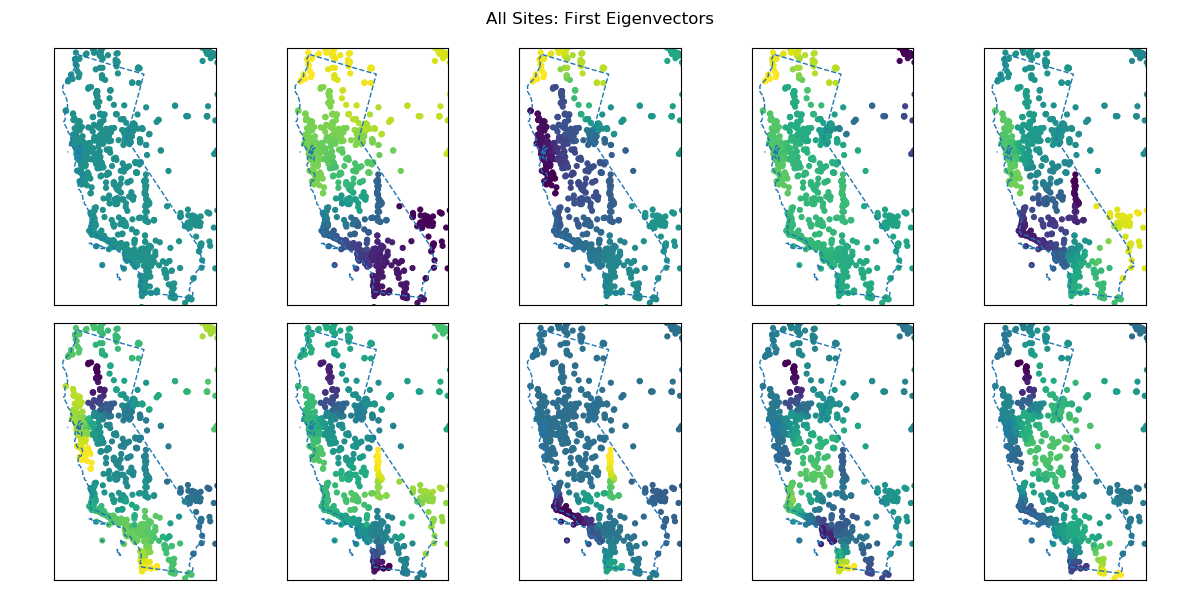

In [88]:
sites = Sites().process(norm=False)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
fig.suptitle('All Sites: First Eigenvectors')

for i, ax in enumerate(axes.flatten()):
    
    cali.plot_outline(ax, dict(color='tab:blue', ls='--', lw=1))
    ax.scatter(sites['x'], sites['y'], s=12, marker='o', alpha=1, c=U[:, i], vmin=U[:, i].min() - 1e-5, vmax=U[:, i].max() + 1e-5)
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)

../geo/sites.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State Code'] = pd.to_numeric(data['State Code'], errors='coerce')


<IPython.core.display.Javascript object>


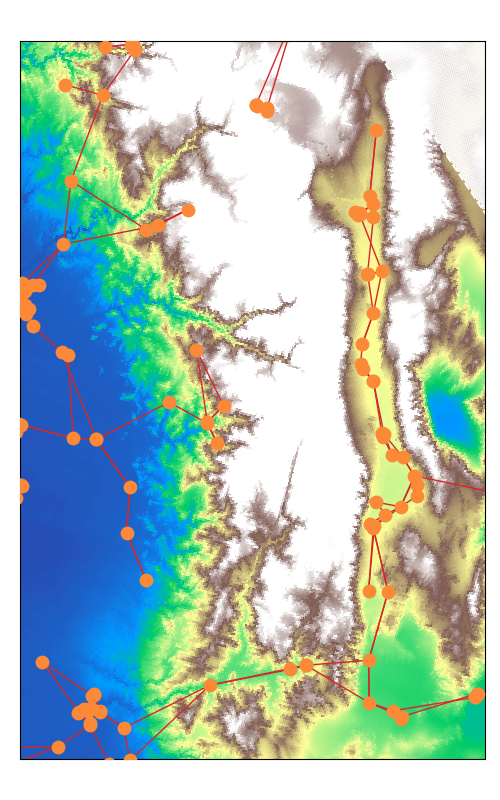

In [68]:
sites = Sites().process(norm=False)

ax = cali.plot_elevation(gridlines=False, outline={'lw': 1.5, 'color': 'white', 'ls': '--'}, back_alpha=0.05)

x, y = sites['x'].values, sites['y'].values



for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], lw=1, color='tab:red', alpha=1, solid_capstyle='round')
    
scat = ax.scatter(sites['x'], sites['y'], s=80, marker='o', alpha=1, c='#fc8937', zorder=np.inf)

    
# scat = ax.scatter(sites['x'], sites['y'], s=5, marker='o', alpha=0.8, c='#fc8937', zorder=np.inf)

ax.set_xlim(-2.09e6, -1.904e6)
ax.set_ylim(-157000, 130000)

plt.tight_layout()


plt.savefig('cali-elev-map-zoomed.jpg', dpi=450)

<IPython.core.display.Javascript object>


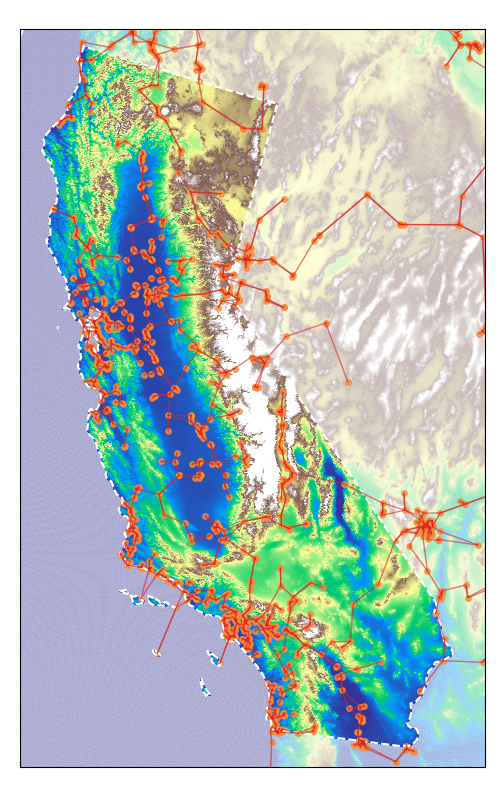

In [69]:
ax = cali.plot_elevation(gridlines=False, outline={'lw': 1.5, 'color': 'white', 'ls': '--'}, back_alpha=0.05)

scat = ax.scatter(sites['x'], sites['y'], s=15, marker='o', alpha=0.8, c='#fc8937')

for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], lw=1, color='tab:red', alpha=0.6, solid_capstyle='round')
    
plt.tight_layout()

plt.savefig('cali-elev-map.jpg', dpi=450)

In [47]:
def get_topo_L(remove_islands=True):
    
    elev = cali.elevation.copy().astype(float)
    elev[elev == -500] = np.nan

    if remove_islands:
        elev[1185:1305, 600:742] = np.nan
        elev[1247:1352, 762:873] = np.nan
        elev[72, 155] = np.nan
        elev[159, 122] = np.nan
        elev[232, 141] = np.nan
        elev[719, 296] = np.nan
        elev[721, 298] = np.nan
        elev[721, 304] = np.nan
        elev[756, 299] = np.nan
        elev[756, 300] = np.nan
        elev[755, 375] = np.nan
        elev[739:744, 374:377] = np.nan
        elev[1380:1395, 980:995] = np.nan
        elev[1666:1672, 1312:1316] = np.nan
        elev[1461:1465, 1042:1046] = np.nan
        elev[1618:1624, 1120:1130] = np.nan
        elev[1667:1670, 1312:1137] = np.nan
        elev[1676:, 1320:1324] = np.nan
        elev[1489, 1388] = np.nan
        elev[1558, 1469] = np.nan
        
    nan_mask_square = ~np.isnan(elev)
    nan_mask_flat = ~np.isnan(elev.reshape(-1))
    N = nan_mask_flat.sum()

    ind = np.zeros_like(elev)
    ind[:] = np.nan
    ind[nan_mask_square] = np.arange(N)
    
    row = np.concatenate([ind[:, :-1].reshape(-1), ind[:, 1:].reshape(-1), ind[:-1, :].reshape(-1), ind[1:, :].reshape(-1)])
    col = np.concatenate([ind[:, 1:].reshape(-1), ind[:, :-1].reshape(-1), ind[1:, :].reshape(-1), ind[:-1, :].reshape(-1)])
    
    mask = ~(np.isnan(row) | np.isnan(col))
    
    row = row[mask]
    col = col[mask]
    
    A = csr_matrix((np.ones(len(row)), (row, col)), shape=(N, N))
    
    D = csr_matrix((np.asarray(A.sum(0)).reshape(-1), (np.arange(N), np.arange(N))), shape=(N, N))
    
    def to_square(v):
        
        out = np.zeros_like(elev)
    
    return D - A
    

In [ ]:
fig, ax = plt.subplots()